In [1]:
!conda install cvxopt numpy scipy cython matplotlib -y

Solving environment: done

# All requested packages already installed.



In [2]:
%load_ext Cython

In [3]:
%%cython

from __future__ import division, print_function
import numpy as np
import math
import scipy.sparse as sp
import cvxopt ; from cvxopt import amd, cholmod

import matplotlib.pyplot as plt
import matplotlib.cm as cm

cimport cython
cimport numpy as np
from libc.math cimport sqrt, ceil
from cython.parallel import prange

#-------------------------------------------------------------------------------
def K_loc(nu):
    "Return local elemental matrix"
    A11 = np.array([[12, 3,-6,-3], [ 3,12, 3, 0], [-6, 3,12,-3], [-3, 0,-3,12]], dtype=np.float_)
    A12 = np.array([[-6,-3, 0, 3], [-3,-6,-3,-6], [ 0,-3,-6, 3], [ 3,-6, 3,-6]], dtype=np.float_)
    B11 = np.array([[-4, 3,-2, 9], [ 3,-4,-9, 4], [-2,-9,-4,-3], [ 9, 4,-3,-4]], dtype=np.float_)
    B12 = np.array([[ 2,-3, 4,-9], [-3, 2, 9,-2], [ 4, 9, 2, 3], [-9,-2, 3, 2]], dtype=np.float_)
    KE  = 1.0/(1.0-nu*nu)/24.0*(     np.block([[A11,A12],[A12.T,A11]])\
                                + nu*np.block([[B11,B12],[B12.T,B11]]))
    return KE

#-------------------------------------------------------------------------------
# This funciton is written in Cython - it has 4 nested loops
#-------------------------------------------------------------------------------
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef prepare_filter(int nelx, int nely, double rmin):
    "Prepare filter matrix and weights"
    cdef int irmin = int(ceil(rmin))
    cdef np.ndarray[long,ndim=1]   iH = np.zeros(nelx*nely*(2*irmin+1)**2,dtype=np.int_)
    cdef np.ndarray[long,ndim=1]   jH = np.zeros_like(iH,dtype=np.int_)
    cdef np.ndarray[double,ndim=1] sH = np.zeros_like(iH,dtype=np.float_)
    cdef int k  = 0, i1, j1, e1, i2, j2, e2
    for i1 in range(nelx):
        for j1 in range(nely):
            e1 = i1*nely+j1
            for i2 in range(max(i1-irmin-1,0),min(i1+irmin,nelx)):
                for j2 in range(max(j1-irmin-1,0),min(j1+irmin,nely)):
                    e2 = i2*nely+j2
                    iH[k] = e1
                    jH[k] = e2
                    sH[k] = max(0,rmin-sqrt((i1-i2)*(i1-i2)+(j1-j2)*(j1-j2)))
                    k += 1
    H = sp.csr_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely))
    Hs= H.dot(np.ones(nelx*nely))
    return H,Hs

#-------------------------------------------------------------------------------
# This funciton is written in Cython, too
#-------------------------------------------------------------------------------
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double OC_update(int nelx, int nely, 
                       double[::1] x, double[::1] xnew, 
                       double volfrac,
                       double[::1] dc, double[::1] dv, double g) nogil:
    "Perform OC update"
    cdef double l1=0.0, l2=1.0E+09, lmid, gt, move=0.2
    cdef int i
    #
    while (l2-l1)/(l1+l2)>1.0E-03:
        lmid=0.5*(l2+l1)
        gt = g
        for i in prange(x.shape[0]):
            xnew[i] = max(0.0,max(x[i]-move,\
                      min(1.0,min(x[i]+move,x[i]*sqrt(-dc[i]/dv[i]/lmid)))))
            gt     += dv[i]*(xnew[i]-x[i])
        if gt>0:
            l1=lmid
        else:
            l2=lmid
    return gt

#-------------------------------------------------------------------------------
def compute_indices(nelx,nely,KE,uplo):
    "Construct the index pointers for the coo format"
    #
    nodenrs = np.reshape(np.arange((1+nelx)*(1+nely),dtype=np.int_),(1+nelx,1+nely))
    edofVec = np.reshape(2*(nodenrs[:-1,:-1]+1),nelx*nely)
    edofMat = np.tile(edofVec,(KE.shape[0],1)).T\
            + np.tile([0, 1, 2*nely+2, 2*nely+3, 2*nely+0, 2*nely+1, -2, -1],(nelx*nely,1))
    #
    iK = np.kron(edofMat,np.ones((KE.shape[0],1),dtype=np.int_)).flatten()
    jK = np.kron(edofMat,np.ones((1,KE.shape[0]),dtype=np.int_)).flatten()
    #
    emx_size = KE.size
    if uplo == 'L':
        half = np.where(iK >= jK)
        halfE= np.where(iK[:emx_size] >= jK[:emx_size])
    elif uplo=='U':
        half = np.where(iK <= jK)
        halfE= np.where(iK[:emx_size] <= jK[:emx_size])
    else:
        raise Exception('Wrong value of uplo')
    #
    iK = iK[half]
    jK = jK[half]
    KEv= KE.flatten()[halfE]
    #
    return edofMat,iK,jK,KEv

#-------------------------------------------------------------------------------
def compute_offset_matrix(iK,jK,CCS):
    "Construct the mapping for quick reassembly from COO to CCS formats"
    offset_I = np.ndarray(iK.shape,dtype=np.int_)
    offset_J = np.arange(iK.shape[0],dtype=np.int_)
    offset_S = np.ones_like(iK,dtype=np.float_)
    #
    cptr = np.array(CCS[0],dtype=np.int_).flatten()
    rowi = np.array(CCS[1],dtype=np.int_).flatten()
    #
    for k in range(iK.shape[0]):
        i = iK[k]
        j = jK[k]
        i0= cptr[j]
        i1= cptr[j+1]
        m = np.searchsorted(rowi[i0:i1],i)
        offset_I[k] = i0+m
    return sp.csr_matrix((offset_S,(offset_I,offset_J)),shape=(rowi.shape[0],iK.shape[0]))

#-------------------------------------------------------------------------------
def renumber_free_dofs(ndof,free,iK,jK):
    "Compute new DOF numbers, omit fixed dofs"
    dof_remap = -1*np.ones(ndof,dtype=np.int_)
    dof_remap[free] = np.arange(free.shape[0],dtype=np.int_)
    free_ind = np.where((dof_remap[iK]>=0) & (dof_remap[jK]>=0))
    iK = dof_remap[iK[free_ind]]
    jK = dof_remap[jK[free_ind]]
    return iK,jK,free_ind

In [4]:
def topopt(nelx,nely,volfrac,penal,rmin,ft,visualize=True):
    print("Minimum compliance problem with OC")
    print("nodes: " + str(nelx) + " x " + str(nely))
    print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
    print("Filter method: " + ["Sensitivity based","Density based"][ft])

    # material properties
    Emax, Emin = 1.0E+00, 1.0E-09
    nu         = 0.3
    #
    ndof       = 2*(nely+1)*(nelx+1)
    nel        = nely*nelx
    # PREPARE FINITE ELEMENT ANALYSIS
    KE      = K_loc(nu)
    # work with only half of the matrix
    uplo = 'U'
    edofMat,iK,jK,KEv = compute_indices(nelx,nely,KE,uplo)

    # Allocate design variables (as array), initialize and allocate sens.
    x    = volfrac * np.ones(nel,dtype=np.float_)
    xold = np.ndarray(x.shape,dtype=np.float_)
    xPhys= x.copy()


    # Filter: Build (and assemble) the index+data vectors for the coo matrix format
    H,Hs = prepare_filter(nelx,nely,rmin)

    g = 0.0

    # BC's and support
    dofs  = np.arange(ndof,dtype=np.int_)
    fixed = np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1],dtype=np.int_))
    free  = np.setdiff1d(dofs,fixed)

    # DOF renumbering to eliminate fixed DOFs
    nfreedofs      = free.shape[0]
    iK,jK,free_ind = renumber_free_dofs(ndof,free,iK,jK)
    
    # Solution and RHS vectors
    f = np.zeros((ndof,1),dtype=np.float_)
    u = np.zeros((ndof,1),dtype=np.float_)

    # Set load
    f[1,0]=-1

    # Initialize plot and plot the initial design
    if visualize:
        fig,ax = plt.subplots()
        ax.set_aspect('equal')
        cmap = cm.get_cmap(name='gist_yarg')
        xViz = np.flip(xPhys.reshape((nelx,nely)),axis=1).T
        qm   = ax.pcolormesh(xViz,cmap=cmap,vmin=0.0,vmax=1.0)
        plt.axis('off')
        fig.show()
    #
    loop   = 0
    change = 1.0

    dv  = np.ones   (nel,dtype=np.float_)
    dc  = np.ndarray(nel,dtype=np.float_)
    ce  = np.ndarray(nel,dtype=np.float_)

    sK  = np.ones(KEv.size*nel,dtype=np.float_)
    K   = cvxopt.spmatrix(sK[free_ind],iK,jK)
    B   = cvxopt.matrix(0.0,(nfreedofs,f.shape[1]))
    KV  = K.V
    ord = amd.order(K,uplo=uplo)
    Kf  = cholmod.symbolic(K,p=ord,uplo=uplo)
    offset = compute_offset_matrix(iK,jK,K.CCS)

    while change>0.01 and loop<2000:
        loop=loop+1
        # Setup and solve FE problem
        sK[:] = np.outer(Emin+(xPhys)**penal*(Emax-Emin),KEv).flatten()
        KV[:] = offset.dot(sK[free_ind]); K.V = KV
        # Solve system
        B[:,:] = f[free,:]
        cholmod.numeric(K,Kf,uplo=uplo)
        cholmod.solve(Kf,B)
        u[free,:]=B

        # Objective and sensitivity
        ce[:] = np.sum((u[edofMat,0].dot(KE))*u[edofMat,0],axis=1)
        c     = np.sum((Emin+(Emax-Emin)*xPhys**penal) * ce)
        dc[:] = -penal*(Emax-Emin)*xPhys**(penal-1)  * ce
        dv[:] = 1.0

        # Filtering:
        if   ft==0:
            dc[:] = H.dot(x*dc)/Hs/np.maximum(1.0e-03,x)
        elif ft==1:
            dc[:] = H.dot(dc/Hs)
            dv[:] = H.dot(dv/Hs)
        else:
            raise Exception('Wrong value of ft')
        #

        # Optimality criteria
        xold[:]=x
        g = OC_update(nelx,nely,xold,x,volfrac,dc,dv,g)

        # Filter design variables
        if   ft==0:
            xPhys[:]=x
        elif ft==1:
            xPhys[:]=H.dot(x)/Hs
        else:
            raise Exception('Wrong value of ft')
        #
        # Compute the change by the inf. norm
        change=np.linalg.norm(x-xold,np.inf)

        # UPDATE PLOT
        if visualize:
            xViz[:] = np.flip(xPhys.reshape((nelx,nely)),axis=1).T
            qm.set_array(xViz.flatten())
            qm.changed()
            fig.canvas.draw()
        #
        
        # Write iteration history to screen (req. Python 2.6 or newer)
        print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
                    loop,c,(g+volfrac*nelx*nely)/(nelx*nely),change))
    #

Minimum compliance problem with OC
nodes: 180 x 60
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Sensitivity based


<IPython.core.display.Javascript object>


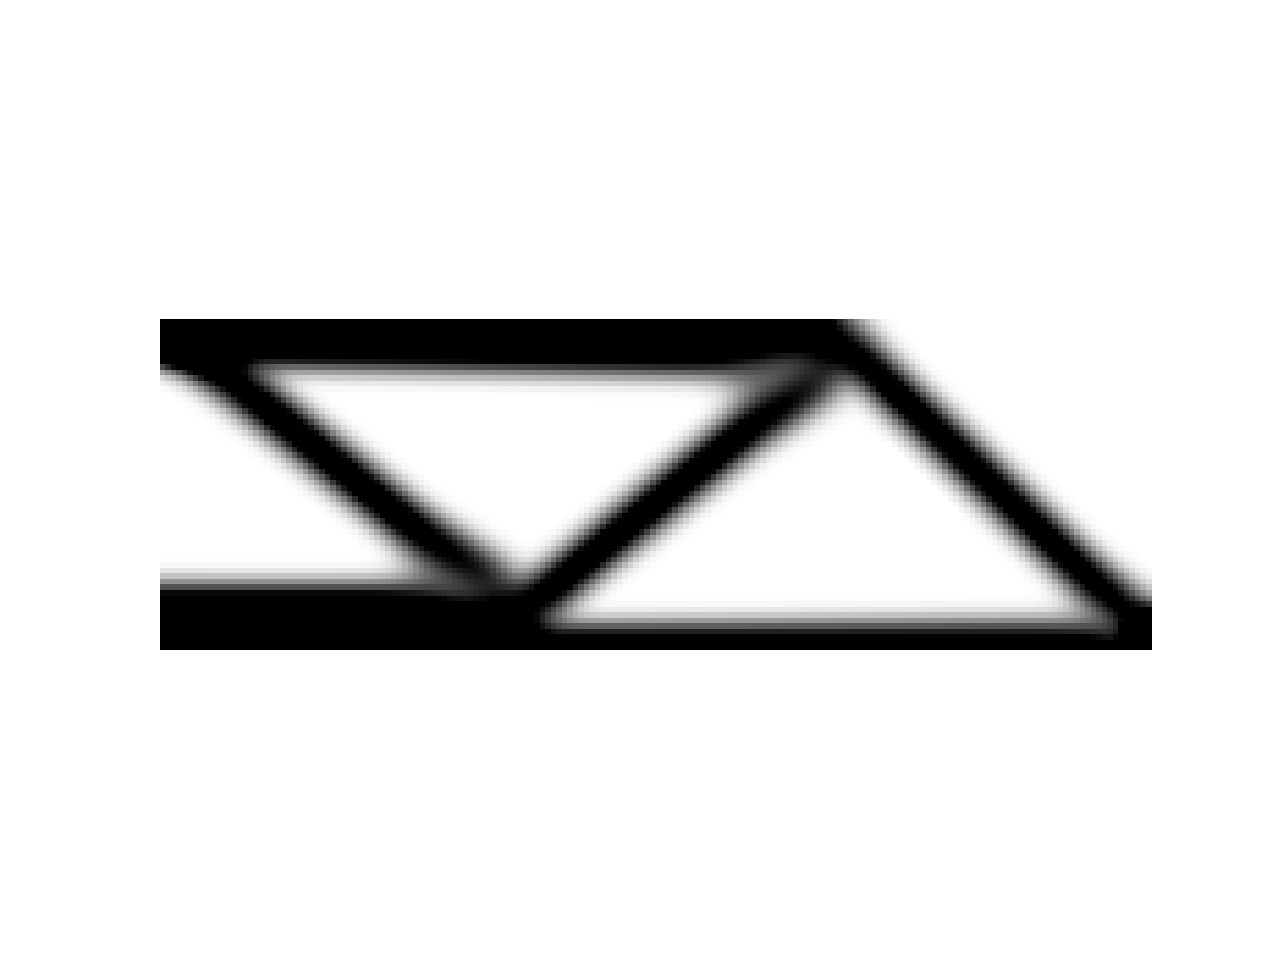

it.: 1 , obj.: 2027.505 Vol.: 0.400, ch.: 0.200
it.: 2 , obj.: 1116.218 Vol.: 0.400, ch.: 0.200
it.: 3 , obj.: 762.909 Vol.: 0.400, ch.: 0.200
it.: 4 , obj.: 600.609 Vol.: 0.400, ch.: 0.200
it.: 5 , obj.: 536.678 Vol.: 0.400, ch.: 0.187
it.: 6 , obj.: 505.323 Vol.: 0.400, ch.: 0.200
it.: 7 , obj.: 485.918 Vol.: 0.400, ch.: 0.158
it.: 8 , obj.: 465.835 Vol.: 0.400, ch.: 0.200
it.: 9 , obj.: 446.183 Vol.: 0.400, ch.: 0.164
it.: 10 , obj.: 427.844 Vol.: 0.400, ch.: 0.200
it.: 11 , obj.: 406.626 Vol.: 0.400, ch.: 0.169
it.: 12 , obj.: 385.074 Vol.: 0.400, ch.: 0.200
it.: 13 , obj.: 359.883 Vol.: 0.400, ch.: 0.200
it.: 14 , obj.: 335.428 Vol.: 0.400, ch.: 0.200
it.: 15 , obj.: 312.767 Vol.: 0.400, ch.: 0.163
it.: 16 , obj.: 296.576 Vol.: 0.400, ch.: 0.162
it.: 17 , obj.: 286.248 Vol.: 0.400, ch.: 0.135
it.: 18 , obj.: 280.060 Vol.: 0.400, ch.: 0.123
it.: 19 , obj.: 275.706 Vol.: 0.400, ch.: 0.108
it.: 20 , obj.: 272.400 Vol.: 0.400, ch.: 0.079
it.: 21 , obj.: 270.239 Vol.: 0.400, ch.: 0.067

In [5]:
%matplotlib notebook

# Input parameters
NNN = 1
nelx, nely = NNN*180, NNN*60
volfrac    = 0.4
rmin       = NNN*5.4
penal      = 3.0
ft=0 # ft==0 -> sens, ft==1 -> dens

import time
t0 = time.perf_counter()
topopt(nelx,nely,volfrac,penal,rmin,ft,visualize=True)
t1 = time.perf_counter()
print("Elapsed time: %f" % (t1-t0))